# Run a grid of models for comparison to cloudy

This version not only runs the models but also does everything that is needed to produce data for the resulsts. 

This should enable one to compare models for various model inputs

This is set up to run macro atoms, but the only difference between this and PythonCloudy should be the inputs

In [16]:
import os
os.getcwd()

'/Users/long/Projects/Python/release-models/cloudy/python'

In [17]:
import subprocess
import numpy as np
import shutil
from glob import glob
from astropy.io import ascii
from astropy.table import Table, join,vstack,hstack
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [18]:
VERSION='87z'
VERSION='87i'

In [19]:
base='''System_type(star,cv,bh,agn,previous)                   bh

### Parameters for the Central Object
Central_object.mass(msol)                  0.8
Central_object.radius(cm)                  1e10
Binary.mass_sec(msol)                           0.4
Binary.period(hr)                             1000

### Parameters for the Disk (if there is one)
Disk.type(none,flat,vertically.extended,rmin>central.obj.rad)                 none

### Parameters for Boundary Layer or the compact object in an X-ray Binary or AGN
Central_object.radiation(yes,no)                  yes
Central_object.rad_type_to_make_wind(bb,models,power,cloudy,brems,mono)               cloudy
Central_object.luminosity(ergs/s)          %.3e
Central_object.power_law_index             -0.9
Central_object.geometry_for_source(sphere,lamp_post,bubble)               sphere
Central_object.cloudy.low_energy_break(ev)                .136
Central_object.cloudy.high_energy_break(ev)               20000

### Parameters describing the various winds or coronae in the system
Wind.number_of_components                  1
Wind.type(SV,star,hydro,corona,kwd,homologous,shell,imported)                shell

### Parameters associated with photon number, cycles,ionization and radiative transfer options
Photons_per_cycle                          10000000
Ionization_cycles                          30
Spectrum_cycles                            0
Wind.ionization(on.the.spot,ML93,LTE_tr,LTE_te,fixed,matrix_bb,matrix_pow,matrix_est)           matrix_pow
Line_transfer(pure_abs,pure_scat,sing_scat,escape_prob,thermal_trapping,macro_atoms_escape_prob,macro_atoms_thermal_trapping)     macro_atoms_thermal_trapping
Matom_transition_mode(mc_jumps,matrix)             mc_jumps
Wind.radiation(yes,no)                           no
Atomic_data                                data/h10_hetop_standard80.dat
# Atomic_data                                zdata/master_cno.dat
Surface.reflection.or.absorption(reflect,absorb,thermalized.rerad)              reflect
Wind_heating.extra_processes(none,adiabatic,nonthermal,both)                 none

### Parameters for Domain 0
Shell.wind_mdot(msol/yr)                   4.7e-20
Shell.wind.radmin(cm)                      1e11
Shell.wind.radmax(cm)                      1.00000000001e11
Shell.wind_v_at_rmin(cm)                   1
Shell.wind.v_at_rmax(cm)                   1.000010
Shell.wind.acceleration_exponent           1
Wind.t.init                                10000
Wind.filling_factor(1=smooth,<1=clumped)   1

### Parameters for Reverberation Modeling (if needed)
Reverb.type(none,photon,wind,matom)                 none

### Other parameters
Photon_sampling.approach(T_star,cv,yso,AGN,tde_bb,min_max_freq,user_bands,cloudy_test,wide,logarithmic)          cloudy_test
Photon_sampling.low_energy_limit(eV)            0.13
Photon_sampling.high_energy_limit(eV)                 1e8
'''

In [20]:
def run_one(log_ip=-8,version=VERSION):

    if log_ip<0:
        pfname='py%s_m%03.2f' % (version,-log_ip)
    else:
        pfname='py%s_p%03.2f' % (version,log_ip)
    

    f=open(pfname+'.pf','w')
    
    xlum=1e21 * 10**(log_ip+8.0)

    print(xlum)
    
    f.write(base % xlum)
    f.close()

    py='py'+version
  

    xcommand='mpirun -np 8 %s -p %s > %s.out.txt' % (py,pfname,pfname)
    print(xcommand)
    subprocess.run(xcommand,shell=True, check=True)

    try:
        signame= '%s.sig' % pfname
        f=open(signame)
    except:
        print('Error: Could not open %s ' % signame)
        return 1
        

    lines=f.readlines()
    last_line=lines[-1]
    print(last_line)
    if last_line.count('COMPLETE'):
        windsave2table = 'windsave2table%s' % version
        xcommand='%s %s >> %s.out.txt' % (windsave2table,pfname,pfname)
        # print(xcommand)
        subprocess.run(xcommand,shell=True, check=True)
        return 0
    return 1
              
run_one()    

1e+21
mpirun -np 8 py87i -p py87i_m8.00 > py87i_m8.00.out.txt
Sun Mar 10 18:34:33 2024     42.6 COMPLETE             py87i_m8.00



0

In [21]:
def do_many(log_ipmin=-5,log_ipmax=8,npts=10,version=VERSION):
    log_ip=np.linspace(log_ipmin,log_ipmax,npts)
    # print(log_ip)
    i=1
    for one in log_ip:
        if one<0:
            pfname='py%s_m%03.2f' % (version,-one)
        else:
            pfname='py%s_p%03.2f' % (version,one)
        ival=run_one(one,version)
        if ival==0:
            os.remove(pfname+'.wind_save')
            shutil.rmtree('diag_%s' % pfname)
            files = glob('%s*spec*' % pfname)
            # print(files)
            for one_file in files:
                os.remove(one_file)
            print('Finished %s successfully (%d/%d)' % (pfname,i,len(log_ip)))
        else:
            print('Failed on %s  (%d/%d)' % (pfname,i,len(log_ip)))
        i+=1
                  
        
            
            
            

do_many(npts=100,version=VERSION)
    
    
    

1e+24
mpirun -np 8 py87i -p py87i_m5.00 > py87i_m5.00.out.txt
Sun Mar 10 18:35:18 2024     44.6 COMPLETE             py87i_m5.00

Finished py87i_m5.00 successfully (1/100)
1.3530477745798076e+24
mpirun -np 8 py87i -p py87i_m4.87 > py87i_m4.87.out.txt
Sun Mar 10 18:36:02 2024     43.3 COMPLETE             py87i_m4.87

Finished py87i_m4.87 successfully (2/100)
1.8307382802953697e+24
mpirun -np 8 py87i -p py87i_m4.74 > py87i_m4.74.out.txt
Sun Mar 10 18:36:46 2024     43.5 COMPLETE             py87i_m4.74

Finished py87i_m4.74 successfully (3/100)
2.477076355991709e+24
mpirun -np 8 py87i -p py87i_m4.61 > py87i_m4.61.out.txt
Sun Mar 10 18:37:30 2024     43.5 COMPLETE             py87i_m4.61

Finished py87i_m4.61 successfully (4/100)
3.3516026509388406e+24
mpirun -np 8 py87i -p py87i_m4.47 > py87i_m4.47.out.txt
Sun Mar 10 18:38:14 2024     43.7 COMPLETE             py87i_m4.47

Finished py87i_m4.47 successfully (5/100)
4.5348785081285823e+24
mpirun -np 8 py87i -p py87i_m4.34 > py87i_m4.34.ou

# Now summarize the results

In [22]:
xfiles=glob('py%s*master.txt'% VERSION)
# xfiles
xroots=[]
for one in xfiles:
    xroots.append(one.replace('.master.txt',''))

xroots=np.sort(xroots)

In [23]:
def get_roots(prefix='py%s' % VERSION):
    xfiles=glob('%s*master.txt' % prefix)
    xorder=[]
    xroot=[]
    for one in xfiles:
        foo=one.replace('.master.txt','')
        xroot.append(foo)
        foo=foo.replace('%s_' % prefix,'')
        foo=foo.replace('p','+')
        foo=foo.replace('m','-')
        xorder.append(eval(foo))
    xtab=Table([xroot,xorder],names=['Root','IP'])
    xtab['IP'].format='.2f'
    xtab.sort('IP')
    return xtab
    

         
    
root_tab=get_roots()        

In [24]:
root_tab

Root,IP
str11,float64
py87i_m8.00,-8.00
py87i_m5.00,-5.00
py87i_m4.87,-4.87
py87i_m4.74,-4.74
py87i_m4.61,-4.61
py87i_m4.47,-4.47
...,...
py87i_p7.21,7.21
py87i_p7.34,7.34


In [25]:
def get_frac(root,element='H'):
    filename='%s.%s.frac.txt' % (root,element)
    try:
        xtab=ascii.read(filename)
        
    except:
        print('Error: could not read %s',filename)
        return None

    colnames=xtab.colnames
    # print(colnames)
    # i=3
    # while i<len(colnames):
    #    xtab.rename_column(colnames[i],colnames[i].replace('i',element))
    #    i+=1
    xtab.remove_column('r')
    xtab.remove_column('inwind')
    return xtab

get_frac('py%s_p0.25' % VERSION,'H')

    

i,i01,i02
int64,float64,float64
0,0.0,0.0
1,4.81e-05,1.0
2,0.0,0.0
3,0.0,0.0


In [26]:
def make_summary_table(roots, element='H',version=VERSION):

    record=[]
    for one in roots:
        xtab=ascii.read(one+'.master.txt')
        ytab=xtab['i','converge','t_e','t_r','ip','xi']
        ztab=ytab[ytab['i']==1]
        # print(ztab)
        htab=get_frac(one,element)
        zztab=join(ztab,htab,join_type='left')
        # hetab=get_frac(one,'He')
        # zztab=join(zztab,hetab,join_type='left')
        # # print(zztab)
        record.append(zztab)

    xxx=vstack(record)

    

    xxx['ip'].format='.3e'
    xxx['xi'].format='.3e'
    xxx['t_e'].format='.3e'
    xxx['t_r'].format='.3e'
    

    xxx.write('Sum_py%s_%s_pl.txt' % (version,element),format='ascii.fixed_width_two_line',overwrite=True)
    return xxx



make_summary_table(root_tab['Root'])
        

i,converge,t_e,t_r,ip,xi,i01,i02
int64,int64,float64,float64,float64,float64,float64,float64
1,1,1.150e+03,7.100e+07,4.730e-10,3.480e-08,0.996,0.00357
1,0,1.590e+03,7.100e+07,4.730e-07,3.480e-05,0.882,0.118
1,0,1.620e+03,7.100e+07,6.400e-07,4.710e-05,0.864,0.136
1,0,1.650e+03,7.100e+07,8.660e-07,6.380e-05,0.842,0.158
1,0,1.690e+03,7.100e+07,1.170e-06,8.630e-05,0.818,0.182
1,0,1.720e+03,7.100e+07,1.590e-06,1.170e-04,0.79,0.21
...,...,...,...,...,...,...,...
1,2,1.060e+07,7.100e+07,7.710e+05,5.680e+07,8.36e-15,1.0
1,2,1.060e+07,7.100e+07,1.040e+06,7.680e+07,6.17e-15,1.0


In [27]:
x=make_summary_table(root_tab['Root'],'He')
x=make_summary_table(root_tab['Root'],'C')
x=make_summary_table(root_tab['Root'],'N')
x=make_summary_table(root_tab['Root'],'O')
x=make_summary_table(root_tab['Root'],'Fe')
# x=make_summary_table(root_tab['Root'],'C')

In [28]:
def do_all(version=VERSION):
    root_tab=get_roots('py%s' % version)
    sum_tab=make_summary_table(root_tab['Root'])
    print(root_tab.info)
    print(sum_tab.info)
    final=hstack([root_tab,sum_tab])
    final.info()
    return final

xfinal=do_all()

<Table length=101>
name  dtype  format
---- ------- ------
Root   str11       
  IP float64    .2f

<Table length=101>
  name    dtype  format
-------- ------- ------
       i   int64       
converge   int64       
     t_e float64    .3e
     t_r float64    .3e
      ip float64    .3e
      xi float64    .3e
     i01 float64       
     i02 float64       

<Table length=101>
  name    dtype  format
-------- ------- ------
    Root   str11       
      IP float64    .2f
       i   int64       
converge   int64       
     t_e float64    .3e
     t_r float64    .3e
      ip float64    .3e
      xi float64    .3e
     i01 float64       
     i02 float64       


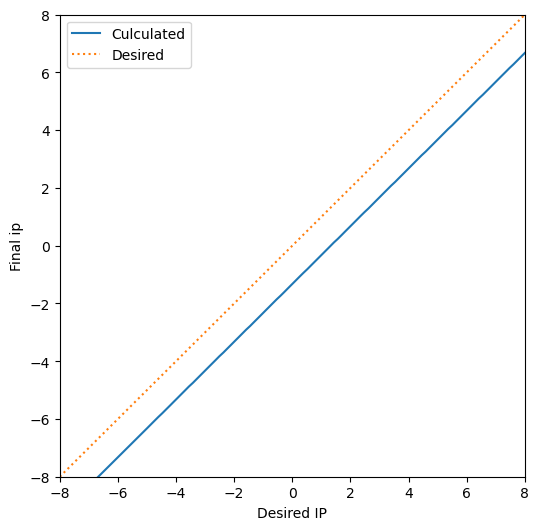

In [29]:
plt.figure(1,(6,6))
plt.plot(xfinal['IP'],np.log10(xfinal['ip']),label='Culculated')
plt.plot([-8,8],[-8,8],':',label='Desired')
plt.xlabel('Desired IP')
plt.ylabel('Final ip')
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.legend()

In [30]:
xfinal.write('toast.txt',format='ascii.fixed_width_two_line',overwrite=True)